In [16]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from poker_utils.constants import HANDS_DICT
from poker_utils.model import analyze_embeddings, save_model_and_embeddings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


In [17]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand')
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")



In [18]:
full_data = pd.concat([base_data, blocker_data, equity_data], axis=1).reset_index()

In [19]:
cols = [
    'suited', 'pair', 'ace', 'broadway_score', 
    'low_pair', 'medium_pair', 'high_pair', 
    'suited_broadway_score', 
    'connector', 'one_gap', 'two_gap', 
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score', 
    'prem_blocker_score_norm', 'block_aa_score', 'block_kk_score',
    'tot_win_perc', 'high_card_win_perc', 'one_pair_win_perc', 
    'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential'
    ]

In [20]:
hands = full_data['hand'].to_numpy()
hand_features = full_data[cols].to_numpy()

ev_features = ev_data.filter(regex='play').to_numpy()

In [21]:
def create_triplets(hand_features, ev_vectors, k_positive=3, k_negative=3):
    triplets = []
    
    similarity_matrix = cosine_similarity(ev_vectors)
    for anchor_idx in range(len(hand_features)):
        similarities = [(i, similarity_matrix[anchor_idx, i]) 
                       for i in range(len(hand_features)) if i != anchor_idx]
        
        similarities.sort(key=lambda x: x[1], reverse=True)
    
        positive_indices = [idx for idx, _ in similarities[:k_positive]]
        negative_indices = [idx for idx, _ in similarities[-k_negative:]]

        for pos_idx in positive_indices:
            for neg_idx in negative_indices:
                triplets.append((
                    hand_features[anchor_idx],
                    hand_features[pos_idx],
                    hand_features[neg_idx]
                ))
    
    return triplets

In [22]:
hands_indices = list(range(169))
train_indices, val_indices = train_test_split(hands_indices, test_size=0.2, random_state=29)

train_features = [hand_features[i] for i in train_indices]
train_evs = ev_features[train_indices]
val_features = [hand_features[i] for i in val_indices]
val_evs = ev_features[val_indices]

train_triplets = create_triplets(train_features, train_evs)
val_triplets = create_triplets(val_features, val_evs)

In [23]:
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets
    
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        return (
            torch.tensor(anchor, dtype=torch.float32), 
            torch.tensor(positive, dtype=torch.float32), 
            torch.tensor(negative, dtype=torch.float32)
            )

In [24]:
train_dataset = TripletDataset(train_triplets)
val_dataset = TripletDataset(val_triplets)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)



In [25]:
class PreFlopEncoder(nn.Module):
    def __init__(self, input_size=36, embedding_dim=8, dropout_rate=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, embedding_dim)
        )
        
    def forward(self, x):
        embedding = self.encoder(x)
        return embedding

In [26]:
def triplet_loss(anchors, positives, negatives, margin=1.0):
    anchors = F.normalize(anchors, p=2, dim=1)
    positives = F.normalize(positives, p=2, dim=1)
    negatives = F.normalize(negatives, p=2, dim=1)
    anchor_positive_dist = F.pairwise_distance(anchors, positives)
    anchor_negative_dist = F.pairwise_distance(anchors, negatives)
    
    losses = torch.relu(anchor_positive_dist - anchor_negative_dist + margin)
    return losses.mean()


In [27]:
def train_model(model, trainloader, valloader, loss_func, optimizer, margin, epochs=10, patience=3):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        tot_train_loss = 0
        for anchor, positive, negative in trainloader:
            optimizer.zero_grad()
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            
            loss = triplet_loss(anchor_emb, positive_emb, negative_emb, margin=margin)
            loss.backward()
            optimizer.step()
            tot_train_loss += loss.item()
        avg_train_loss = tot_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        tot_val_loss = 0
        with torch.no_grad():
            for anchor, positive, negative in valloader:
                anchor_emb = model(anchor)
                positive_emb = model(positive)
                negative_emb = model(negative)
                
                val_loss = loss_func(anchor_emb, positive_emb, negative_emb, margin=margin)
                tot_val_loss += val_loss.item()
        
        avg_val_loss = tot_val_loss / len(valloader)
        val_losses.append(avg_val_loss)
        
        if epoch % (epochs//5) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            
            torch.save(model.state_dict(), 'model_weights/best_triplet_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
    model.load_state_dict(torch.load('model_weights/best_triplet_model.pt', weights_only=True))
    return train_losses, val_losses


In [28]:
def plot_train_loss(train_losses, val_losses, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
model = PreFlopEncoder(embedding_dim=8)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Epoch 1/50, Train Loss: 0.7604, Val Loss: 0.3570
Epoch 11/50, Train Loss: 0.0395, Val Loss: 0.2610
Early stopping at epoch 11


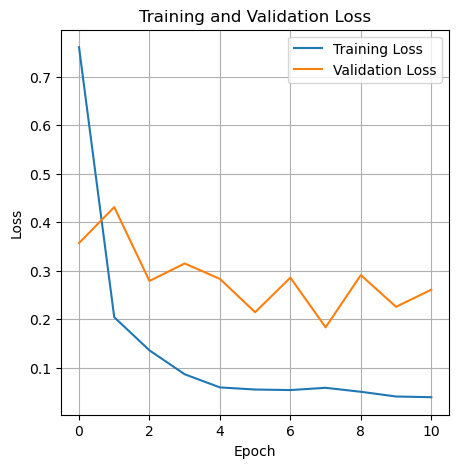

In [30]:
train_losses, val_losses = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    loss_func=triplet_loss,
    optimizer=optimizer,
    margin=1.5,
    epochs=50,
    patience=3
)
plot_train_loss(train_losses, val_losses)

In [31]:
full_data = torch.tensor(hand_features, dtype=torch.float32)
model.eval()
with torch.no_grad():
    embeddings = model(full_data).detach().numpy()

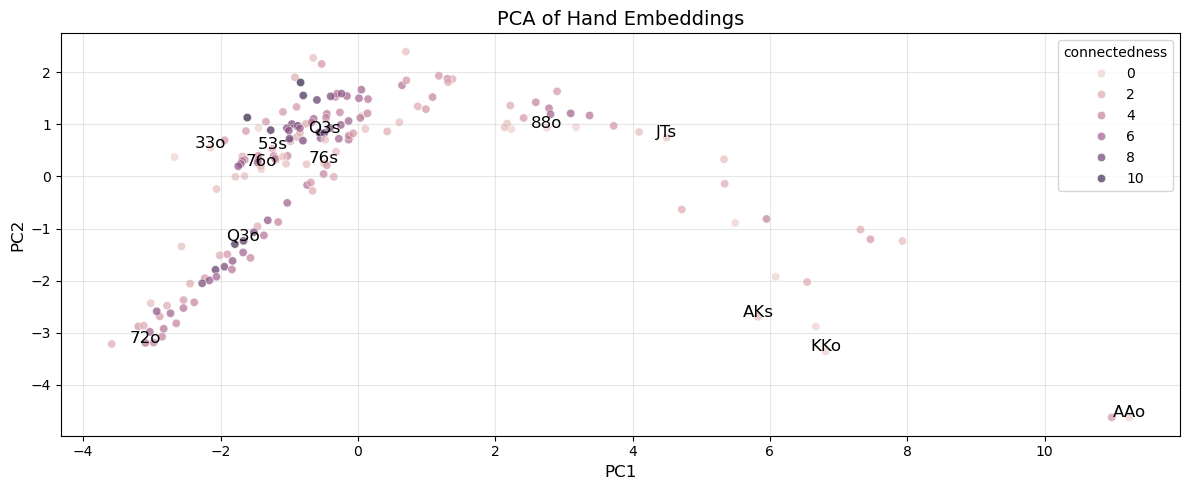

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  AJs (0.9975)  JJo (0.9970)  QQo (0.9953)  J2s (-0.9867)   
1   KKo  AKs (0.9941)  QQo (0.9938)  AAo (0.9913)  J7s (-0.9835)   
2   72o  73o (0.9999)  83o (0.9998)  84o (0.9998)  A7s (-0.9664)   
3   76s  65s (0.9994)  54s (0.9982)  43s (0.9951)  KJs (-0.9878)   
4   76o  87o (0.9981)  43s (0.9976)  65o (0.9965)  KJs (-0.9865)   
5   Q3s  J3s (0.9991)  J2s (0.9990)  Q2s (0.9988)  AJs (-0.9852)   
6   Q3o  Q2o (0.9998)  Q4o (0.9991)  J6o (0.9989)  A9s (-0.9696)   
7   88o  99o (0.9834)  77o (0.9645)  A6s (0.9550)  84o (-0.9139)   
8   JTs  AKo (0.9874)  QJs (0.9868)  AJo (0.9814)  97o (-0.9720)   
9   33o  22o (0.9976)  87o (0.9927)  98o (0.9916)  ATs (-0.9848)   
10  AKs  KKo (0.9941)  QQo (0.9920)  AJs (0.9905)  J7s (-0.9845)   
11  53s  42s (0.9973)  64s (0.9965)  73s (0.9933)  KJs (-0.9740)   

         bottom_2       bottom_3  
0   Q9o (-0.9868)  98s (-0.9926)  
1   Q6s (-0.9847)  JTo (-0.9854)  
2   A8s (-

In [32]:
similarity_df = analyze_embeddings(
    embeddings, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='connectedness',
    figsize=(12,5)
    )

In [ ]:

# save_model_and_embeddings(
#     embeddings,
#     'preflop_embeddings_triplet',
#     model,
#     "preflop_triplet_weights"
#     )
